## Description:

    Use DeSeq2 to identify differential abundance among treatments
    Following  Ashley's succ-C notebook


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.0.0’
[1] "gridExtra"
[1] ‘2.0.0’
[1] "scales"
[1] ‘0.3.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.4.0’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.2’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [6]:
%%R

#re-order levels 
sample_data(physeq.Full)$Plant = relevel(sample_data(physeq.Full)$Plant, "BARE")

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels

sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)


In [7]:
%%R
## Create phyloseq object on subset of samples
physeq.plant = subset_samples(physeq.Full, Plant != "BARE")
sample_data(physeq.plant)$PlantRep = interaction(sample_data(physeq.plant)$Rep, sample_data(physeq.plant)$Plant)

In [8]:
%%R
physeq.bare = subset_samples(physeq.Full, Plant == "BARE")
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 50 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


# Create DESeq object and view results for Bare and Planted Seperately

## ~Plant + Treatment + Plant:Treatment

In [9]:
%%R
dds = phyloseq_to_deseq2(physeq.plant, ~Plant + Treatment + Plant:Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: gene-wise dispersion estimates: 20 workers

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: mean-dispersion relationship

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

 [1] "Intercept"                 "Plant75.062"              
 [3] "PlantABUTH"                "PlantAMAPO"               
 [5] "PlantB73"                  "PlantB97"                 
 [7] "PlantECHCG"                "PlantELCOR"               
 [9] "PlantERATE"                "PlantFAGES"               
[11] "PlantGLYMA"                "PlantH99"                 
[13] "PlantHELAN"                "PlantHp301"               
[15] "PlantIl14H"                "PlantKi3"                 
[17] "PlantMo18"                 "PlantMS71"                
[19] "PlantOh7B"                 "PlantSETFA"               
[21] "PlantSORBI"                "PlantSORSUD"              
[23] "PlantTx303"                "TreatmentNneg"            
[25] "TreatmentNpos"             "Plant75.062.TreatmentNneg"
[27] "PlantABUTH.TreatmentNneg"  "PlantAMAPO.TreatmentNneg" 
[29] "PlantB73.TreatmentNneg"    "PlantB97.TreatmentNneg"   
[31] "PlantECHCG.TreatmentNneg"  "PlantELCOR.TreatmentNneg" 
[33] "PlantERATE.Treatme

In [10]:
%%R
res = results(d_dds, contrast = c("Treatment", "Npos", "Nneg"), parallel = TRUE)

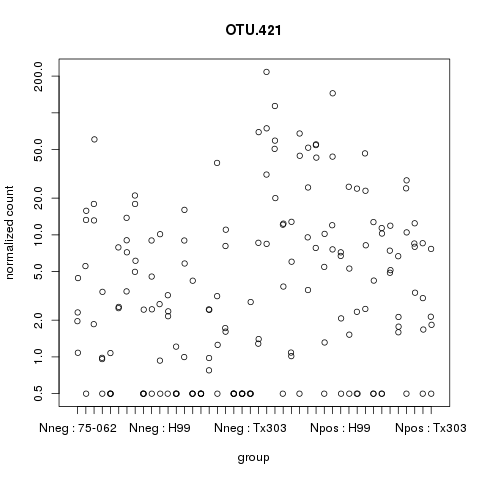

In [11]:
%%R
plotCounts(dds, gene=which.min(res$padj), intgroup=c("Treatment", "Plant"))

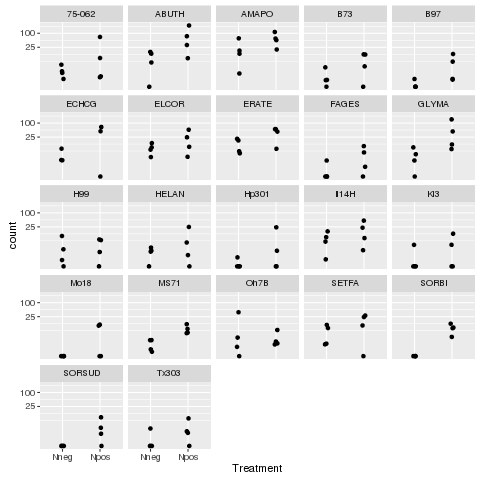

In [12]:
%%R
d = plotCounts(dds, gene=which.min(res$padj), intgroup=c("Plant","Treatment"), returnData = TRUE)
 

ggplot(d, aes(x=Treatment, y=count)) +
  geom_point(position=position_jitter(w=0.1,h=0)) +
    facet_wrap(~Plant) +
  scale_y_log10(breaks=c(25,100,400))

## ~PlantRep + Treatment

In [13]:
%%R
dds = phyloseq_to_deseq2(physeq.plant, ~PlantRep + Treatment)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: factor levels were dropped which had no samples

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: NOTE: fitType='parametric', but the dispersion trend was not well captured by the
  function: y = a/x + b, and a local regression fit was automatically substituted.
  specify fitType='local' or 'mean' to avoid this message next time.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


 [1] "Intercept"        "PlantRep1.75.062" "PlantRep2.75.062" "PlantRep3.75.062"
 [5] "PlantRep4.75.062" "PlantRep1.ABUTH"  "PlantRep2.ABUTH"  "PlantRep3.ABUTH" 
 [9] "PlantRep4.ABUTH"  "PlantRep1.AMAPO"  "PlantRep2.AMAPO"  "PlantRep3.AMAPO" 
[13] "PlantRep4.AMAPO"  "PlantRep1.B73"    "PlantRep2.B73"    "PlantRep3.B73"   
[17] "PlantRep4.B73"    "PlantRep1.B97"    "PlantRep2.B97"    "PlantRep3.B97"   
[21] "PlantRep4.B97"    "PlantRep1.ECHCG"  "PlantRep2.ECHCG"  "PlantRep3.ECHCG" 
[25] "PlantRep1.ELCOR"  "PlantRep2.ELCOR"  "PlantRep3.ELCOR"  "PlantRep4.ELCOR" 
[29] "PlantRep1.ERATE"  "PlantRep2.ERATE"  "PlantRep3.ERATE"  "PlantRep4.ERATE" 
[33] "PlantRep1.FAGES"  "PlantRep2.FAGES"  "PlantRep3.FAGES"  "PlantRep4.FAGES" 
[37] "PlantRep1.GLYMA"  "PlantRep2.GLYMA"  "PlantRep3.GLYMA"  "PlantRep4.GLYMA" 
[41] "PlantRep1.H99"    "PlantRep2.H99"    "PlantRep3.H99"    "PlantRep4.H99"   
[45] "PlantRep1.HELAN"  "PlantRep2.HELAN"  "PlantRep3.HELAN"  "PlantRep4.HELAN" 
[49] "PlantRep1.Hp301"  "Pla

In [14]:
%%R
res = results(d_dds, alpha=0.05, parallel = TRUE)

In [15]:
%%R
df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)
    df = df[!is.na(df$padj),]

    TT = physeq.plant %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, by = 'OTU')
    

df.sig = d[d$padj <0.05,]
df.sig %>% arrange(padj) 

      baseMean log2FoldChange       pvalue         padj       OTU    Rank1
1    13.251085      2.0885071 4.067204e-18 9.118671e-15  OTU.7380 Bacteria
2    29.595477      1.1553152 1.359027e-17 1.523469e-14    OTU.92 Bacteria
3    11.352326      1.6458058 1.061747e-15 7.934792e-13   OTU.421 Bacteria
4     7.285241      1.2081368 3.916956e-14 2.195454e-11   OTU.988 Bacteria
5    28.814155      1.0972142 4.476881e-11 2.007433e-08 OTU.10249 Bacteria
6    10.979446      1.2423261 2.101017e-09 7.850799e-07   OTU.442 Bacteria
7     1.265182      1.5142541 3.456617e-09 1.107105e-06  OTU.2231 Bacteria
8     1.960587      1.3210372 4.957367e-09 1.389302e-06  OTU.1130 Bacteria
9    11.298332     -0.4826339 1.266107e-08 3.154014e-06   OTU.226 Bacteria
10   13.258802      0.5782799 1.984365e-08 4.448946e-06   OTU.242 Bacteria
11   43.038375      0.8931523 2.993142e-08 6.100567e-06  OTU.1403 Bacteria
12    3.991401      1.1950933 4.009746e-08 7.491542e-06  OTU.1353 Bacteria
13   16.148713      0.630

## Bare plots ~DAP*Rep + Treatment

In [16]:
%%R
bare_dds = phyloseq_to_deseq2(physeq.bare, ~DAP*Rep + Treatment)
bare_d_dds = DESeq(bare_dds, parallel = TRUE)
resultsNames(bare_d_dds)


 [1] "Intercept"     "DAP36"         "DAP53"         "DAP57"        
 [5] "DAP61"         "DAP72"         "DAP79"         "DAP84"        
 [9] "DAP88"         "Rep1"          "Rep2"          "Rep3"         
[13] "Rep4"          "TreatmentNneg" "TreatmentNpos" "DAP36.Rep1"   
[17] "DAP53.Rep1"    "DAP57.Rep1"    "DAP61.Rep1"    "DAP72.Rep1"   
[21] "DAP79.Rep1"    "DAP84.Rep1"    "DAP88.Rep1"    "DAP36.Rep2"   
[25] "DAP53.Rep2"    "DAP57.Rep2"    "DAP61.Rep2"    "DAP72.Rep2"   
[29] "DAP79.Rep2"    "DAP84.Rep2"    "DAP88.Rep2"    "DAP36.Rep3"   
[33] "DAP53.Rep3"    "DAP57.Rep3"    "DAP61.Rep3"    "DAP72.Rep3"   
[37] "DAP79.Rep3"    "DAP84.Rep3"    "DAP88.Rep3"    "DAP36.Rep4"   
[41] "DAP53.Rep4"    "DAP57.Rep4"    "DAP61.Rep4"    "DAP72.Rep4"   
[45] "DAP79.Rep4"    "DAP84.Rep4"    "DAP88.Rep4"   


In [17]:
%%R
res = results(bare_d_dds, alpha = 0.1, parallel = TRUE)
summary(res)


out of 4928 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



* Not a single OTU is significantly enriched overall in bare soils with N treatment

## Bare ~ DAP:Rep + DAP:Treatment

In [18]:
%%R
bare_dds = phyloseq_to_deseq2(physeq.bare, ~Rep + DAP + DAP:Treatment)
bare_d_dds = DESeq(bare_dds, parallel = TRUE)
resultsNames(bare_d_dds)


 [1] "Intercept"           "Rep1"                "Rep2"               
 [4] "Rep3"                "Rep4"                "DAP36"              
 [7] "DAP53"               "DAP57"               "DAP61"              
[10] "DAP72"               "DAP79"               "DAP84"              
[13] "DAP88"               "DAP36.TreatmentNneg" "DAP53.TreatmentNneg"
[16] "DAP57.TreatmentNneg" "DAP61.TreatmentNneg" "DAP72.TreatmentNneg"
[19] "DAP79.TreatmentNneg" "DAP84.TreatmentNneg" "DAP88.TreatmentNneg"
[22] "DAP36.TreatmentNpos" "DAP53.TreatmentNpos" "DAP57.TreatmentNpos"
[25] "DAP61.TreatmentNpos" "DAP72.TreatmentNpos" "DAP79.TreatmentNpos"
[28] "DAP84.TreatmentNpos" "DAP88.TreatmentNpos"


In [19]:
%%R
res = results(bare_d_dds, alpha = 0.05, parallel = TRUE, contrast = c("Treatment", "Npos", "Nneg"))
summary(res)


Error in do.call(rbind, bplapply(levels(idx), function(l) { : 
  error in evaluating the argument 'args' in selecting a method for function 'do.call': Error: 20 errors; first error:
  Error in cleanContrast(object[idx == l, , drop = FALSE], contrast, expanded = isExpanded, : TreatmentNpos and TreatmentNneg are expected to be in resultsNames(object)

For more information, use bplasterror(). To resume calculation, re-call
  the function and set the argument 'BPRESUME' to TRUE or wrap the
  previous call in bpresume().

First traceback:
  32: (structure(function (expr, envir = parent.frame(), enclos = if (is.list(envir) || 
          is.pairlist(envir)) parent.frame() else baseenv()) 
      {
          force(envir)
          force(enclos)
          standardGeneric("eval")
      }, generic = structure("eval", package = "BiocGenerics"), package = "BiocGenerics", group = list(), valueClass = character(0), signature = c("expr", 
      "envir"), default = structure(function (expr, envir = par

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in do.call(rbind, bplapply(levels(idx), function(l) { : 
  error in evaluating the argument 'args' in selecting a method for function 'do.call': Error: 20 errors; first error:
  Error in cleanContrast(object[idx == l, , drop = FALSE], contrast, expanded = isExpanded, : TreatmentNpos a

In [20]:
%%R
df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)
    df = df[!is.na(df$padj),]

    TT = physeq.plant %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, by = 'OTU')
    

#df.sig = d[d$padj <0.05,]
#df.sig %>% arrange(padj) 

In [22]:
%%R
asNumeric = function(x) { as.numeric(as.character(x)) }

## interested in both organisms that increase or decrease in abundance
get_Ps = function(physeq.obj, l2fc_threshold) {
    diagdds = phyloseq_to_deseq2(physeq.obj, ~Rep + Treatment)
    diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)
    r = results(diagdds, lfcThreshold = l2fc_threshold, independentFiltering = TRUE)
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    df$OTU = rownames(df)

    TT = physeq.obj %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    return(d)
}

#Function to trim physeq object to just samples to include in Deseq analysis
deseq_prune = function(physeq.obj, plant, day) {
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$Plant %in% c("BARE", plant))&
                     (physeq.md$DAP == day), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > 0, TRUE)
    return(p.thresh)
}

## Define deseq object Full dataset

In [23]:
%%R
diagdds = phyloseq_to_deseq2(physeq, ~DAP + PlantRep + Treatment)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)


Error in sample_data(physeq, FALSE) : 
  error in evaluating the argument 'object' in selecting a method for function 'sample_data': Error: object 'physeq' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in sample_data(physeq, FALSE) : 
  error in evaluating the argument 'object' in selecting a method for function 'sample_data': Error: object 'physeq' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R    
    theta = 0.5
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "p")])
    df$p.adj = p.adjust(df$p, "BH")

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R
summary(res)

### Model only results in one marginally significant OTU - 
Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae

## Deseq analysis on just the plants

Note that model with DAP is not full rank so it cannot run with DAP as a controlling factor

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq.plant, ~ PlantRep + Treatment)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R
summary(res)

In [ ]:
%%R    
    theta = 0.5
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "p")])
    df$p.adj = p.adjust(df$p, "BH")

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R -w 800 -h 600
sigtab = d[d$p.adj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=5) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

## Create Deseq object for just the bare soils

In [ ]:
%%R
## Create phyloseq object on subset of samples
physeq.bare = subset_samples(physeq.Full, Plant == "BARE")
sample_data(physeq.bare)$DAPRep = interaction(sample_data(physeq.bare)$DAP, sample_data(physeq.bare)$Rep)

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq.bare, ~ DAPRep + Treatment)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R
summary(res)

In [ ]:
%%R    
    theta = 0.0
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "p")])
    df$p.adj = p.adjust(df$p, "BH")

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R
sigtab

In [ ]:
%%R -w 800 -h 600
sigtab = d[d$p.adj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=5) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))

## Test other N status indicators

In [ ]:
%%R
physeq.d15N = subset_samples(physeq.Full, !is.na(d15N))
physeq.d15N

In [ ]:
%%R
diagdds = phyloseq_to_deseq2(physeq.d15N, ~ d15N)
diagdds = DESeq(diagdds, quiet = TRUE, parallel = TRUE)

In [ ]:
%%R
res = results(diagdds, parallel = TRUE, independentFiltering = TRUE)

In [ ]:
%%R
head(res)

In [ ]:
%%R    
#
    #theta = 0.0
    #beta = res$log2FoldChange
    #betaSE = res$lfcSE
    #p = pnorm(beta, theta, betaSE, lower.tail = FALSE)
    #res$p = p
    df = as.data.frame(res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
    

df$OTU = rownames(df)

    TT = physeq.Full %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(df, TT, c('OTU'))
    d %>% head %>% print

In [ ]:
%%R
sigtab = d[d$padj < .05,]
dim(sigtab)

In [ ]:
%%R -w 800 -h 600
sigtab = d[d$padj < .05,]
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2)) + geom_point(size=5) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))